In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
import os
from tqdm import tqdm

SystemError: 0 147399��() method: bad call flags

In [ ]:
# Colab root
# dataset_root = "/content/drive/MyDrive/likelion/smartphone_defect_segmentation/data/Mobile Phone Defect"

# Local root
dataset_root = "/Users/mungughyeon/Library/CloudStorage/GoogleDrive-moonstalker9010@gmail.com/내 드라이브/likelion/smartphone_defect_segmentation/data/Mobile Phone Defect"
records = []
image_class = ["good", "stain", "scratch", "oil"]

for class_name in image_class:
    class_path = os.path.join(dataset_root, class_name)

    if not os.path.isdir(class_path):
        continue

    for file in tqdm(os.listdir(class_path)):
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            img_path = os.path.join(class_path, file)

            img = cv2.imread(img_path)
            if img is None:
                continue

            h, w, c = img.shape

            # 클래스별로 마스크 찾기
            mask_path = None
            mask_name = file.replace('.jpg', '.png')

            if class_name == "stain":
                # Sta_0001.jpg -> Sta_0001.png (ground_truth_1)
                potential_mask = os.path.join(dataset_root, "ground_truth_1", mask_name)
                if os.path.exists(potential_mask):
                    mask_path = potential_mask
            # elif class_name == "good":
            #     # Good_0001.jpg -> Good_0001.png (ground_truth_1)
            #     potential_mask = os.path.join(dataset_root, "ground_truth_1", mask_name)
            #     if os.path.exists(potential_mask):
            #         mask_path = potential_mask
            elif class_name == "scratch":
                # Scr_0001.jpg -> Scr_0001.png (ground_truth_1)
                potential_mask = os.path.join(dataset_root, "ground_truth_1", mask_name)
                if os.path.exists(potential_mask):
                    mask_path = potential_mask
            elif class_name == "oil":
                # Oil_0001.jpg -> Oil_0001.png (ground_truth_2)
                potential_mask = os.path.join(dataset_root, "ground_truth_2", mask_name)
                if os.path.exists(potential_mask):
                    mask_path = potential_mask

            records.append({
                "class": class_name,
                "file_name": file,
                "image_path": img_path,
                "mask_path": mask_path,
                "height": h,
                "width": w,
                "channels": c,
            })

df = pd.DataFrame(records)
df

100%|██████████| 400/400 [00:09<00:00, 43.95it/s]


,class,file_name,image_path,mask_path,height,width,channels
0,good,0006.png,/Users/mungughyeon/Library/CloudStorage/Google...,None,1080,1920,3
1,good,0012.png,/Users/mungughyeon/Library/CloudStorage/Google...,None,1080,1920,3
2,good,0013.png,/Users/mungughyeon/Library/CloudStorage/Google...,None,1080,1920,3
3,good,0007.png,/Users/mungughyeon/Library/CloudStorage/Google...,None,1080,1920,3
4,good,0011.png,/Users/mungughyeon/Library/CloudStorage/Google...,None,1080,1920,3
...,...,...,...,...,...,...,...
1215,oil,Oil_0082.jpg,/Users/mungughyeon/Library/CloudStorage/Google...,/Users/mungughyeon/Library/CloudStorage/Google...,1080,1920,3
1216,oil,Oil_0257.jpg,/Users/mungughyeon/Library/CloudStorage/Google...,/Users/mungughyeon/Library/CloudStorage/Google...,1080,1920,3
1217,oil,Oil_0243.jpg,/Users/mungughyeon/Library/CloudStorage/Google...,/Users/mungughyeon/Library/CloudStorage/Google...,1080,1920,3
1218,oil,Oil_0294.jpg,/Users/mungughyeon/Library/CloudStorage/Google...,/Users/mungughyeon/Library/CloudStorage/Google...,1080,1920,3


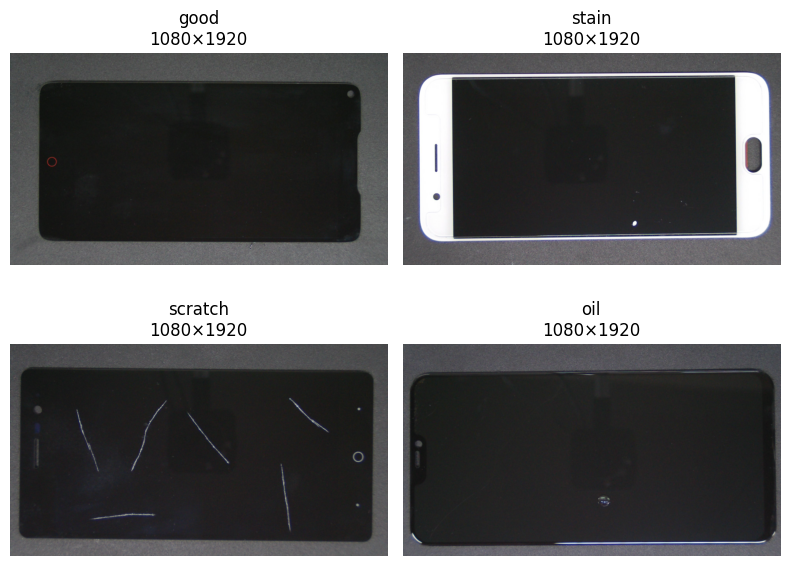

In [ ]:
plt.figure(figsize=(8, 12))

classes = df["class"].unique()

for idx, cls in enumerate(classes):
    # 각 클래스에서 1장씩 랜덤 샘플링
    sample_row = df[df["class"] == cls].sample(1, random_state=42).iloc[0]

    img = cv2.imread(sample_row["image_path"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    h, w, _ = img.shape

    # 4행 x 2열 구조
    plt.subplot(len(classes), 2, idx + 1)
    plt.imshow(img)
    plt.title(f"{cls}\n{h}×{w}")
    plt.axis("off")

plt.tight_layout()
plt.show()

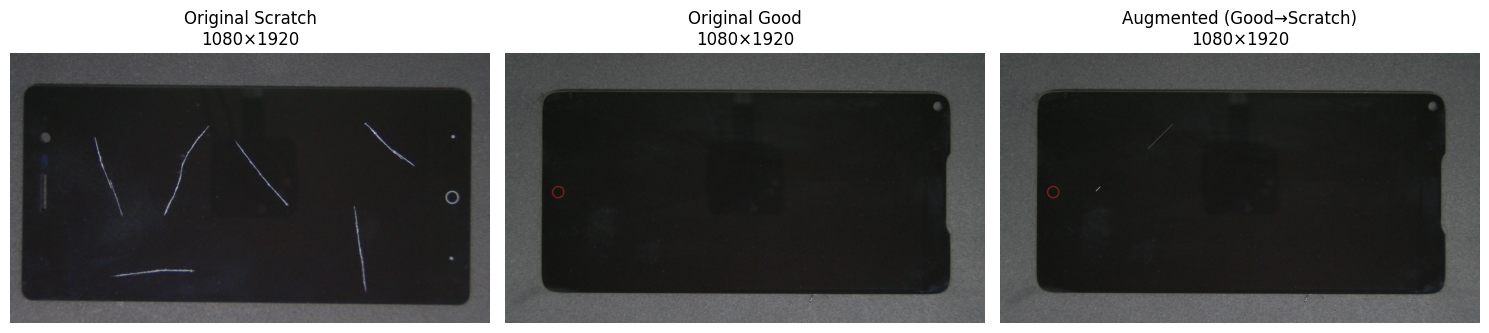

In [ ]:
plt.figure(figsize=(15, 5))

# 1. 원본 스크래치 이미지
scratch_sample = df[df["class"] == "scratch"].sample(1, random_state=42).iloc[0]
scratch_img = cv2.imread(scratch_sample["image_path"])
scratch_img = cv2.cvtColor(scratch_img, cv2.COLOR_BGR2RGB)

# 2. Good 클래스 샘플 이미지
good_sample = df[df["class"] == "good"].sample(1, random_state=42).iloc[0]
good_img = cv2.imread(good_sample["image_path"])
good_img = cv2.cvtColor(good_img, cv2.COLOR_BGR2RGB)

# 3. Good 이미지에 더 자연스러운 스크래치 증강 적용
height, width = good_img.shape[:2]
augmented_img = good_img.copy()

# 핸드폰 화면 영역을 더 보수적으로 설정
screen_margin_h = int(height * 0.25)  # 상하 25% 여백
screen_margin_w = int(width * 0.2)    # 좌우 20% 여백
screen_top = screen_margin_h
screen_bottom = height - screen_margin_h
screen_left = screen_margin_w
screen_right = width - screen_margin_w

num_scratches = random.randint(2, 6)
for _ in range(num_scratches):
    # 스크래치 타입 랜덤 선택 (대각선 확률 높임)
    scratch_type = random.choices(
        ['horizontal', 'diagonal', 'curved'],
        weights=[20, 60, 20]  # diagonal 60% 확률
    )[0]

    # 더 투명한 설정 (0.15-0.4)
    alpha = random.uniform(0.15, 0.4)

    if scratch_type == 'horizontal':
        # 가로 스크래치 - 더 얇게
        y = random.randint(screen_top, screen_bottom - 20)
        x_start = random.randint(screen_left, screen_right - 150)
        scratch_length = random.randint(80, 200)
        x_end = min(x_start + scratch_length, screen_right)
        thickness = random.randint(1, 2)  # 2-5 → 1-2로 감소

        for i in range(thickness):
            if y + i < height:
                # 원본과 스크래치 색상을 블렌딩
                original_color = augmented_img[y+i:y+i+1, x_start:x_end]
                scratch_color = np.full_like(original_color, [255, 255, 255])
                blended = (1 - alpha) * original_color + alpha * scratch_color
                augmented_img[y+i:y+i+1, x_start:x_end] = blended.astype(np.uint8)

    elif scratch_type == 'diagonal':
        # 대각선 스크래치 - 더 얇게
        x_start = random.randint(screen_left, screen_right - 100)
        y_start = random.randint(screen_top, screen_bottom - 100)
        length = random.randint(50, 120)
        thickness = random.randint(1, 2)  # 2-4 → 1-2로 감소

        # 대각선 방향 설정
        direction_x = random.choice([-1, 1])
        direction_y = random.choice([-1, 1])

        for i in range(length):
            x = x_start + i * direction_x
            y = y_start + i * direction_y

            # 화면 영역 내에서만 그리기
            if screen_left <= x < screen_right and screen_top <= y < screen_bottom:
                # 두께를 위해 주변 픽셀도 채우기
                for tx in range(-thickness//2, thickness//2 + 1):
                    for ty in range(-thickness//2, thickness//2 + 1):
                        if 0 <= x+tx < width and 0 <= y+ty < height:
                            # 투명도 적용
                            original = augmented_img[y+ty, x+tx]
                            scratch = np.array([255, 255, 255])
                            blended = (1 - alpha) * original + alpha * scratch
                            augmented_img[y+ty, x+tx] = blended.astype(np.uint8)

    elif scratch_type == 'curved':
        # 곡선 스크래치 - 더 얇게
        x_start = random.randint(screen_left, screen_right - 100)
        y_start = random.randint(screen_top, screen_bottom - 100)

        # 제어점들
        x_mid = x_start + random.randint(-50, 50)
        y_mid = y_start + random.randint(-50, 50)
        x_end = x_start + random.randint(40, 100)
        y_end = y_start + random.randint(-40, 40)

        # 화면 영역 내로 제한
        x_mid = max(screen_left, min(x_mid, screen_right))
        y_mid = max(screen_top, min(y_mid, screen_bottom))
        x_end = max(screen_left, min(x_end, screen_right))
        y_end = max(screen_top, min(y_end, screen_bottom))

        # 곡선 점들 생성
        points = []
        for t in np.linspace(0, 1, 60):
            x = int((1-t)**2 * x_start + 2*(1-t)*t * x_mid + t**2 * x_end)
            y = int((1-t)**2 * y_start + 2*(1-t)*t * y_mid + t**2 * y_end)
            if screen_left <= x < screen_right and screen_top <= y < screen_bottom:
                points.append((x, y))

        # 곡선 그리기 - 더 얇게
        thickness = 1  # 1-3 → 1로 고정
        for x, y in points:
            if 0 <= x < width and 0 <= y < height:
                # 투명도 적용
                original = augmented_img[y, x]
                scratch = np.array([255, 255, 255])
                blended = (1 - alpha) * original + alpha * scratch
                augmented_img[y, x] = blended.astype(np.uint8)

# 시각화
plt.subplot(1, 3, 1)
plt.imshow(scratch_img)
plt.title(f'Original Scratch\n{scratch_img.shape[0]}×{scratch_img.shape[1]}')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(good_img)
plt.title(f'Original Good\n{good_img.shape[0]}×{good_img.shape[1]}')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(augmented_img)
plt.title(f'Augmented (Good→Scratch)\n{augmented_img.shape[0]}×{augmented_img.shape[1]}')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# # Source - https://stackoverflow.com/q
# # Posted by NECben067
# # Retrieved 2026-01-06, License - CC BY-SA 4.0

# height = 384
# width = 384
# blank_image = np.zeros((height, width, 3), np.uint8)

# num_scratches= random.randint(0,5)
# for _ in range(num_scratches):
#     row_random = random.randint(20,370)
#     blank_image[row_random:(row_random+1), row_random:(row_random+random.randint(25,75))] = (255,255,255)

# cv2.imshow("synthetic", blank_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [ ]:
import sys
sys.path.append("../")
from src.segtool.augmentation import CVAugmentor

Processed good: 0006.png
Processed stain: Sta_0142.jpg
Processed scratch: Scr_0384.jpg
Processed oil: Oil_0186.jpg


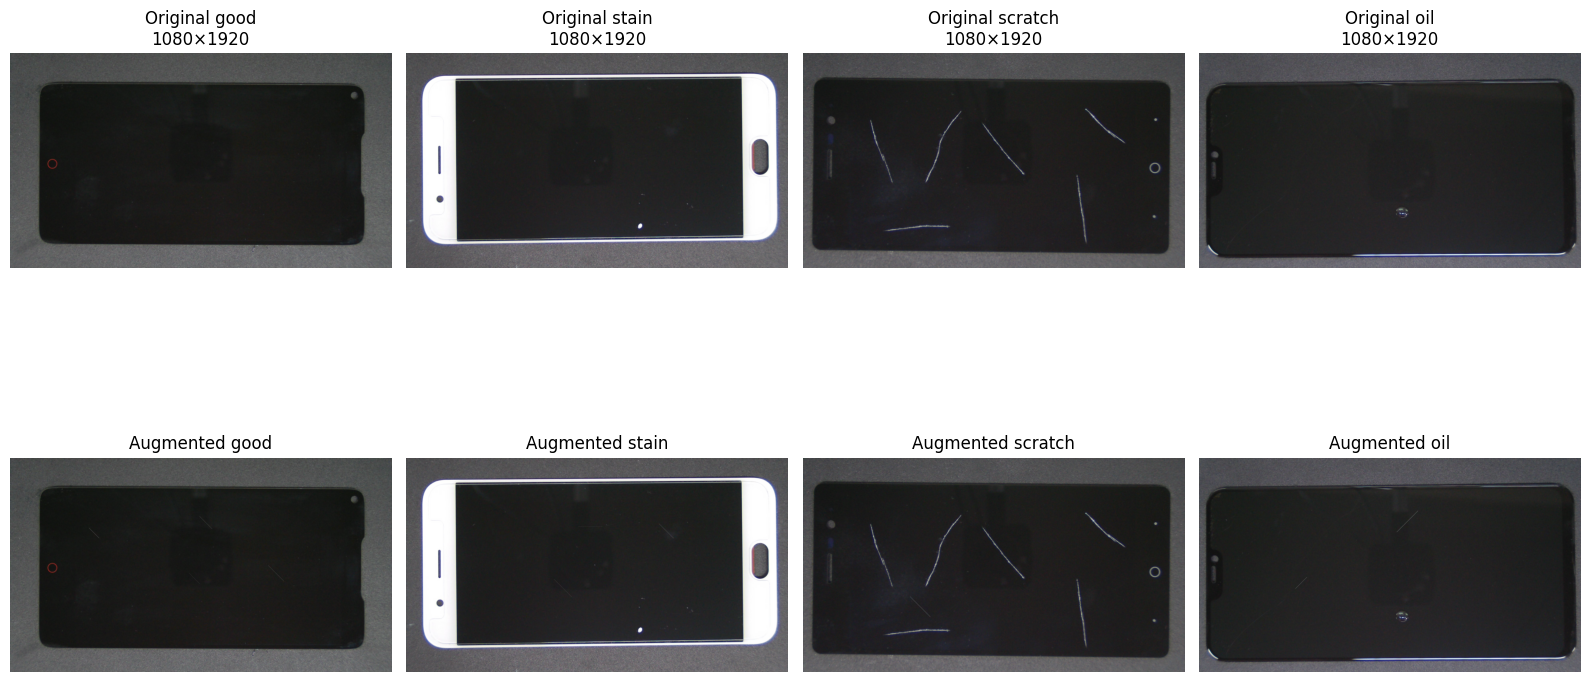

In [ ]:
# CVAugmentor 초기화
augmentor = CVAugmentor()

# 각 클래스별로 1장씩 샘플 선택 및 증강
plt.figure(figsize=(16, 10))

classes = df["class"].unique()

for idx, cls in enumerate(classes):
    # 각 클래스에서 1장씩 랜덤 샘플링
    sample_row = df[df["class"] == cls].sample(1, random_state=42).iloc[0]

    # 원본 이미지 로드
    original_img = cv2.imread(sample_row["image_path"])
    original_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    # 스크래치 증강 적용
    augmented_img = augmentor.apply_scratch_augmentation(original_img)
    augmented_rgb = cv2.cvtColor(augmented_img, cv2.COLOR_BGR2RGB)

    # 원본 이미지 표시 (상단 행)
    plt.subplot(2, len(classes), idx + 1)
    plt.imshow(original_rgb)
    plt.title(f'Original {cls}\n{original_rgb.shape[0]}×{original_rgb.shape[1]}')
    plt.axis('off')

    # 증강된 이미지 표시 (하단 행)
    plt.subplot(2, len(classes), idx + 1 + len(classes))
    plt.imshow(augmented_rgb)
    plt.title(f'Augmented {cls}')
    plt.axis('off')

    print(f"Processed {cls}: {sample_row['file_name']}")

plt.tight_layout()
plt.show()

### masking 자동화 알고리즘?

In [1]:
# SAM 2 설치
!pip install git+https://github.com/facebookresearch/segment-anything-2.git

# 모델 가중치 다운로드 (가장 성능이 좋은 Large 모델 기준)
!wget https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt

  Cloning https://github.com/facebookresearch/segment-anything-2.git to /tmp/pip-req-build-5cijdu31
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything-2.git /tmp/pip-req-build-5cijdu31
  Resolved https://github.com/facebookresearch/segment-anything-2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 7.1 MB/s eta 0:00:00
  Created wheel for SAM-2: filename=sam_2-1.0-cp312-cp312-linux_x86_64.whl size=501908 sha256=8c4de0ab9d05755811857048c3b5b5b76d1184495a6b7f5b26f48fea096cd910
  Stored in directory: /tmp/pip-ephem-wheel-cache-wpgdirq3/wheels/b0/5b/a1/c16dafb8c3c0046f1158e7fa7570559a72085df5beab759ba0
  Created wheel 

✅ 이미지를 성공적으로 불러왔습니다.
⏳ 마스크 생성 중... (잠시만 기다려 주세요)
✨ 총 5개의 세그먼트 영역을 발견했습니다.
💾 마스크 저장 완료: /content/drive/MyDrive/likelion/smartphone_defect_segmentation/data/Mobile Phone Defect/real/scratch_mask_result.png


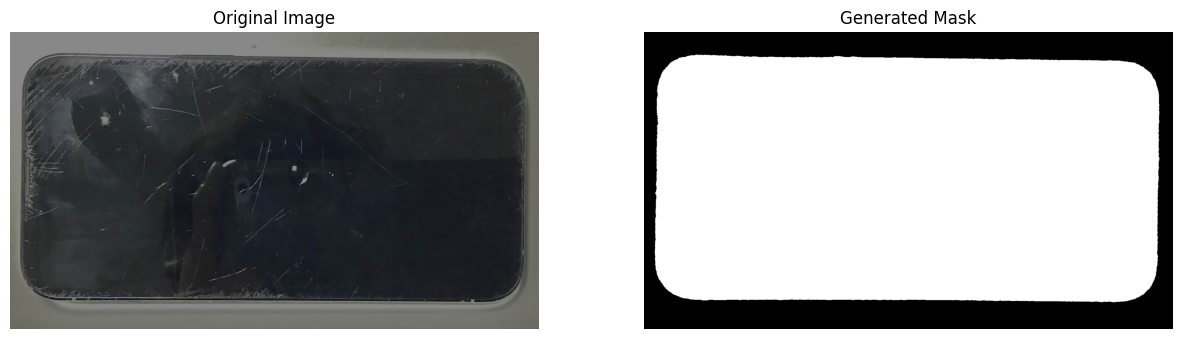

In [4]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

# 1. 경로 및 모델 설정
# 사용자님의 구글 드라이브 경로
base_path = "/content/drive/MyDrive/likelion/smartphone_defect_segmentation/data/Mobile Phone Defect/real"
image_name = 'real_scratch_1.jpeg'
full_path = os.path.join(base_path, image_name)

# 장치 설정 (GPU 필수)
device = "cuda" if torch.cuda.is_available() else "cpu"
model_cfg = "sam2_hiera_l.yaml"
checkpoint = "sam2_hiera_large.pt"

# 2. 이미지 로드 체크
image = cv2.imread(full_path)
if image is None:
    print(f"❌ 파일을 찾을 수 없습니다: {full_path}")
else:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print("✅ 이미지를 성공적으로 불러왔습니다.")

    # 3. SAM 2 모델 로드
    sam2 = build_sam2(model_cfg, checkpoint, device=device, apply_postprocessing=False)

    # 4. 자동 마스크 생성기 설정 (스크래치 최적화)
    # points_per_side: 숫자를 높일수록 촘촘하게 검사하여 미세한 기스를 더 잘 잡습니다.
    mask_generator = SAM2AutomaticMaskGenerator(
        model=sam2,
        points_per_side=64,           # 64 또는 128 추천 (스크래치 밀도에 따라 조절)
        points_per_batch=128,
        pred_iou_thresh=0.7,          # 마스크 품질 임계값
        stability_score_thresh=0.92,  # 마스크 안정성 점수
        min_mask_region_area=50       # 너무 작은 점(노이즈) 제거
    )

    # 5. 마스크 생성 (연산 시작 - 시간이 수십 초 정도 소요될 수 있습니다)
    print("⏳ 마스크 생성 중... (잠시만 기다려 주세요)")
    masks = mask_generator.generate(image)
    print(f"✨ 총 {len(masks)}개의 세그먼트 영역을 발견했습니다.")

    # 6. 마스크 통합 및 저장 함수
    def process_and_save_masks(anns, output_name='scratch_mask_result.png'):
        if len(anns) == 0:
            print("❌ 생성된 마스크가 없습니다.")
            return

        # 이미지 크기에 맞는 빈 검은색 도화지 생성
        h, w = anns[0]['segmentation'].shape
        combined_mask = np.zeros((h, w), dtype=np.uint8)

        # 찾은 모든 마스크를 하나로 합침 (흰색으로 채움)
        for ann in anns:
            m = ann['segmentation']
            combined_mask[m] = 255

        # 결과 저장 (드라이브 경로에 저장하거나 현재 경로에 저장)
        save_path = os.path.join(base_path, output_name)
        cv2.imwrite(save_path, combined_mask)
        print(f"💾 마스크 저장 완료: {save_path}")

        plt.figure(figsize=(15, 10))

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(combined_mask, cmap='gray')
        plt.title("Generated Mask")
        plt.axis('off')

        plt.show()

    # 실행
    process_and_save_masks(masks)

✅ 이미지를 성공적으로 불러왔습니다.
⏳ 마스크 생성 중... (정밀 탐색 모드)
✨ 총 51개의 후보 영역을 발견했습니다.
마스크 저장 완료: /content/drive/MyDrive/likelion/smartphone_defect_segmentation/data/Mobile Phone Defect/real/final_scratch_mask.png


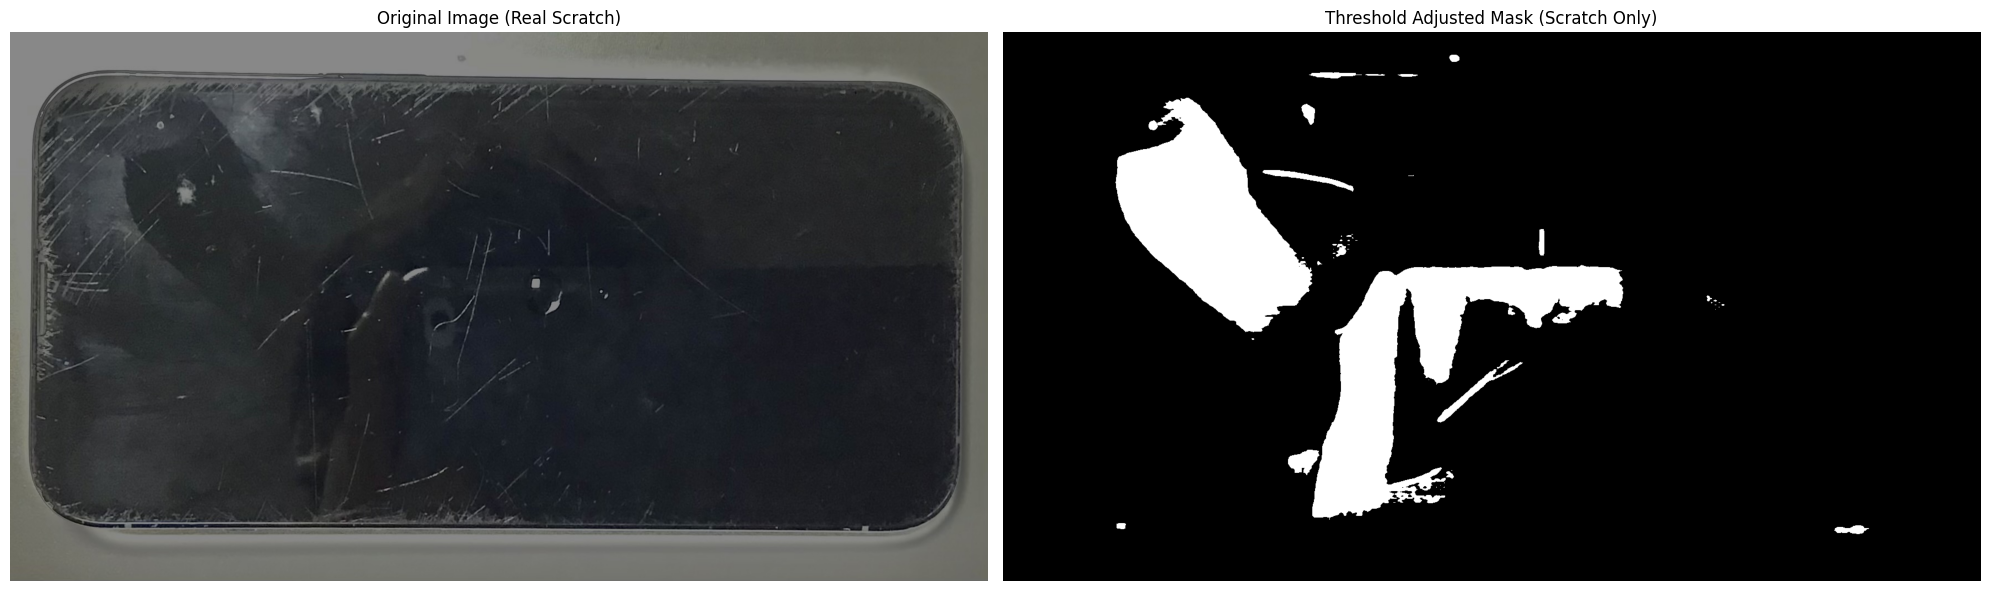

In [7]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

# 1. 경로 및 모델 설정
base_path = "/content/drive/MyDrive/likelion/smartphone_defect_segmentation/data/Mobile Phone Defect/real"
image_name = 'real_scratch_1.jpeg'
full_path = os.path.join(base_path, image_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
model_cfg = "sam2_hiera_l.yaml"
checkpoint = "sam2_hiera_large.pt"

# 2. 이미지 로드
image = cv2.imread(full_path)
if image is None:
    print(f"❌ 파일을 찾을 수 없습니다: {full_path}")
else:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print("✅ 이미지를 성공적으로 불러왔습니다.")

    # 3. SAM 2 모델 로드
    sam2 = build_sam2(model_cfg, checkpoint, device=device, apply_postprocessing=False)

    # 4. 자동 마스크 생성기 설정 (기스 추출을 위한 Threshold 조정)
    mask_generator = SAM2AutomaticMaskGenerator(
        model=sam2,
        points_per_side=128,          # 더 촘촘하게 점을 찍어 미세한 선을 탐색
        points_per_batch=64,
        pred_iou_thresh=0.4,          # 낮출수록 희미한 기스도 포함시킴
        stability_score_thresh=0.4,   # 낮출수록 확실하지 않은(흐릿한) 선도 인식
        min_mask_region_area=1,       # 아주 작은 픽셀 단위 기스도 유지
    )

    # 5. 마스크 생성
    print("⏳ 마스크 생성 중... (정밀 탐색 모드)")
    masks = mask_generator.generate(image)
    print(f"✨ 총 {len(masks)}개의 후보 영역을 발견했습니다.")

    # 6. 마스크 통합 및 시각화 함수
    def process_and_visualize(anns, output_name='final_scratch_mask.png'):
        if len(anns) == 0:
            print("❌ 생성된 마스크가 없습니다.")
            return

        h, w = anns[0]['segmentation'].shape
        combined_mask = np.zeros((h, w), dtype=np.uint8)

        # 전체 이미지 면적 (너무 큰 빛 반사 영역을 제거하기 위함)
        total_area = h * w

        # 찾은 마스크 중 크기가 너무 큰 것(액정 전체, 큰 빛 반사)은 필터링
        for ann in anns:
            # 이미지 전체 면적의 5% 미만인 작은 객체(기스 후보)만 합침
            if ann['area'] < (total_area * 0.05):
                m = ann['segmentation']
                combined_mask[m] = 255

        # 결과 저장
        save_path = os.path.join(base_path, output_name)
        cv2.imwrite(save_path, combined_mask)
        print(f"마스크 저장 완료: {save_path}")

        # 나란히 시각화
        plt.figure(figsize=(20, 10))

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title("Original Image (Real Scratch)")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(combined_mask, cmap='gray')
        plt.title("Threshold Adjusted Mask (Scratch Only)")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    # 실행
    process_and_visualize(masks)